In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")
from Scripts import train_metric_learning, run_metric_learning_inference, train_gnn, run_gnn_inference, build_track_candidates, evaluate_candidates
from Scripts.utils.convenience_utils import get_example_data, plot_true_graph, get_training_metrics, plot_training_metrics, plot_neighbor_performance, plot_predicted_graph, plot_track_lengths, plot_edge_performance, plot_graph_sizes
import yaml

import warnings
warnings.filterwarnings("ignore")
CONFIG = 'pipeline_config.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Download Data

In [2]:
!mkdir datasets
!wget https://portal.nersc.gov/cfs/m3443/dtmurnane/TrackML_Example/trackml_quickstart_dataset.tar.gz -O datasets/trackml_quickstart_dataset.tar.gz

mkdir: cannot create directory ‘datasets’: File exists
--2022-06-17 14:39:55--  https://portal.nersc.gov/cfs/m3443/dtmurnane/TrackML_Example/trackml_quickstart_dataset.tar.gz
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.107, 128.55.206.109, 128.55.206.106, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49146568 (47M) [application/x-gzip]
Saving to: ‘datasets/trackml_quickstart_dataset.tar.gz’

datasets/trackml_qu 100%[===================>]  46.87M   121MB/s    in 0.4s    

2022-06-17 14:39:55 (121 MB/s) - ‘datasets/trackml_quickstart_dataset.tar.gz’ saved [49146568/49146568]



In [3]:
%%capture
!tar -xvf datasets/trackml_quickstart_dataset.tar.gz -C datasets;
!rm datasets/trackml_quickstart_dataset.tar.gz

### Pipeline configurations

The configurations for the entire pipeline are defined under pipeline_config.yml. 

In [2]:
with open(CONFIG, 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)

# 1. Train Metric Learning

## What it does
Broadly speaking, the first stage of our pipeline is embedding the space points on to graphs, in a way that is efficient, i.e. we miss as few points on a graph as possible. We train a MLP to transform the input feature vector of each space point $\mathbf{u}_i$ into an N-dimensional latent space $\mathbf{v}_i$. The graph is then constructed by connecting the space points whose Euclidean distance between the latent space points $$d_{ij} = \left| \mathbf{v}_i - \mathbf{v}_j \right| < r_{embedding}$$

## Training data
Let us take a look at the data before training. In this example pipeline, we have preprocessed the TrackML data into a more convenient form. We calculated directional information and summary statistics from the charge deposited in each spacepoints, and append them to its cyclidrical coordinates. Let us load an example data file and inspect the content.

In [4]:
example_data_df, example_data_pyg = get_example_data(configs)
example_data_df.head()

Loading BokehJS ...

Loading BokehJS ...

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.323412,2.091356,0.844154,0.05,0.05625,0.3,-2.091356,0.962261,0.051929,0.083736,-0.958000
1,6.0,0.308704,0.884925,1.229181,0.10,0.28125,0.3,0.800960,1.972132,0.115441,0.501320,-0.198762
2,6.0,0.312759,0.793395,1.423718,0.05,0.33750,0.3,0.956851,2.072294,0.031444,0.612759,0.041935
3,7.0,0.342820,0.772962,1.282741,0.10,0.33750,0.3,0.928149,-0.127298,0.031484,-0.159847,-0.085926
4,3.0,0.162364,1.440542,0.844154,0.10,0.11250,0.3,0.348650,2.327071,0.071830,0.609832,-0.018804


In [16]:
plot_true_graph(example_data_pyg, num_tracks=200)

Loading BokehJS ...

Loading BokehJS ...

## Train metric learning model

Finally we come to model training. By default, we train the MLP for 30 epochs, which takes approximately 15 minutes on an NVidia V100. Feel free to adjust the epoch number in pipeline_config.yml

In [2]:
metric_learning_trainer, metric_learning_model = train_metric_learning(CONFIG)

INFO:-------------------- Step 1: Running metric learning training --------------------
INFO:----------------------------- a) Initialising model -----------------------------
INFO:------------------------------ b) Running training ------------------------------
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 3.2 M 
---------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.730    Total estimated model params size (MB)


Epoch 29: 100%|██████████| 90/90 [00:20<00:00,  4.34it/s, loss=0.00734, v_num=15]


INFO:-------------------------------- c) Saving model --------------------------------


## Plot training metrics

We can examine how the training went. This is stored in a simple dataframe:

In [3]:
embedding_metrics = get_training_metrics(metric_learning_trainer)
embedding_metrics.head()

,epoch,train_loss,val_loss,eff,pur,current_lr
0,0,0.009961,0.009849,0.786237,0.009588,0.0001
1,1,0.009898,0.009825,0.876660,0.010691,0.0002
2,2,0.009838,0.009765,0.933365,0.011383,0.0003
3,3,0.009790,0.009690,0.955407,0.011651,0.0004
4,4,0.009741,0.009602,0.972288,0.011857,0.0005


In [4]:
plot_training_metrics(embedding_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [5]:
plot_neighbor_performance(metric_learning_model)

## Plot example truth and predicted graphs

In [6]:
plot_predicted_graph(metric_learning_model)

## Track lengths

In [7]:
plot_track_lengths(metric_learning_model)

Loading BokehJS ...

Loading BokehJS ...

100%|██████████| 80/80 [00:11<00:00,  7.11it/s]


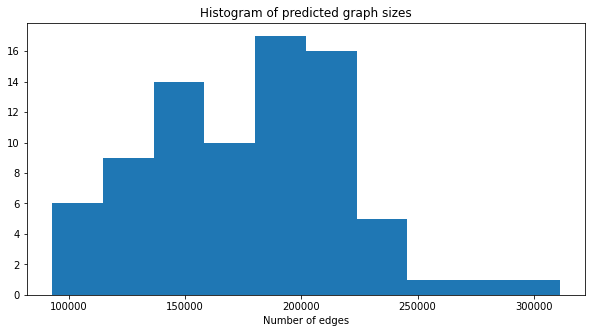

In [13]:
plot_graph_sizes(metric_learning_model)

# 2. Construct graphs from metric learning inference

This step performs model inference on the entire input datasets (train, validation and test), to obtain input graphs to the graph neural network. Optionally, we also clear the directory.

In [20]:
graph_builder = run_metric_learning_inference(CONFIG)

Loading BokehJS ...

Loading BokehJS ...

INFO:------------- Step 2: Constructing graphs from metric learning model -------------
INFO:---------------------------- a) Loading trained model ----------------------------
INFO:----------------------------- b) Running inferencing -----------------------------


Training finished, running inference to build graphs...


100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


# 3. Train graph neural networks

We have a set of graphs constructed. We now train a GNN to classify edges as either "true" (belonging to the same track) or "false" (not belonging to the same track).

In [22]:
gnn_trainer, gnn_model = train_gnn(CONFIG)

INFO:-------------------------  Step 3: Running GNN training  -------------------------
INFO:----------------------------- a) Initialising model -----------------------------
INFO:------------------------------ b) Running training ------------------------------
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 35.2 K
1 | edge_encoder           | Sequential | 66.4 K
2 | edge_network           | Sequential | 82.8 K
3 | node_network           | Sequential | 82.8 K
4 | output_edge_classifier | Sequential | 83.2 K
------------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.402     Total estimated model params size (MB)


Epoch 39: 100%|██████████| 90/90 [00:26<00:00,  3.40it/s, loss=0.0732, v_num=4]


INFO:-------------------------------- c) Saving model --------------------------------


## Plot training metrics

In [23]:
gnn_metrics = get_training_metrics(gnn_trainer)
gnn_metrics.head()

,epoch,train_loss,val_loss,eff,pur,current_lr
0,0,0.767799,0.785991,0.796564,0.609125,0.0002
1,1,0.711122,0.756100,0.756937,0.667293,0.0004
2,2,0.643303,0.672148,0.845987,0.670632,0.0006
3,3,0.589438,0.604562,0.865171,0.706723,0.0008
4,4,0.638630,0.555818,0.877254,0.731507,0.0010


In [24]:
plot_training_metrics(gnn_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [25]:
plot_edge_performance(gnn_model)

# Step 4: GNN inference 

In [26]:
run_gnn_inference(CONFIG)

INFO:--------------------- Step 4: Scoring graph edges using GNN  ---------------------
INFO:---------------------------- a) Loading trained model ----------------------------
INFO:----------------------------- b) Running inferencing -----------------------------


Training finished, running inference to filter graphs...
Building train


100%|██████████| 80/80 [00:04<00:00, 16.54it/s]


Building val


100%|██████████| 10/10 [00:00<00:00, 16.39it/s]


Building test


100%|██████████| 10/10 [00:00<00:00, 16.92it/s]


# Step 5: Build track candidates from GNN

In [27]:
build_track_candidates(CONFIG)

INFO:-----------  Step 5: Building track candidates from the scored graph  -----------
INFO:---------------------------- a) Loading scored graphs ----------------------------
INFO:---------------------------- b) Labelling graph nodes ----------------------------
100%|██████████| 100/100 [00:02<00:00, 48.24it/s]


# Step 6: Evaluate track candidates

We can control the matching style in the pipeline config file. The following all require at least a majority of hits to match in each scheme (i.e. matching fraction = 50%).
A discussion of each matching style and some worked examples can be found in the [Documentation](https://hsf-reco-and-software-triggers.github.io/Tracking-ML-Exa.TrkX/performance/matching_definitions/).

ATLAS style matching is the default.

INFO:------------ Step 6: Evaluating the track reconstruction performance ------------
INFO:--------------------------- a) Loading labelled graphs ---------------------------
100%|██████████| 100/100 [00:02<00:00, 33.40it/s]
INFO:--------------------- b) Calculating the performance metrics ---------------------
INFO:Number of reconstructed particles: 110480
INFO:Number of particles: 114164
INFO:Number of matched tracks: 116793
INFO:Number of tracks: 117412
INFO:Number of duplicate reconstructed particles: 6285
INFO:Efficiency: 0.968
INFO:Fake rate: 0.005
INFO:Duplication rate: 0.057
INFO:------------------------------ c) Plotting results ------------------------------


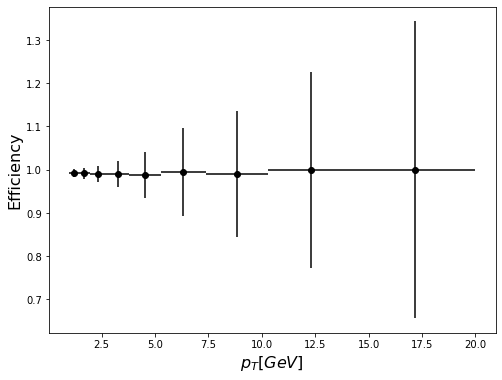

In [28]:
evaluated_events, reconstructed_particles, particles, matched_tracks, tracks = evaluate_candidates(CONFIG)